<a href="https://colab.research.google.com/github/claudia-hm/FinalProject_IRWA/blob/main/homework_1_o4ds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1 : Semisupervised Learning

Carlo De Dominicis, Claudia Herron Mulet, Federico Medici, Nicolò Malatesta

## 0. Set-up

In [ ]:
import time
import random
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import chebyshev
from scipy.spatial.distance import mahalanobis
from scipy.spatial.distance import minkowski
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [ ]:
file_X_l = "x_l.npy"
file_X_u = "x_u.npy"
file_Y_l = "y_l.npy"
file_symmetric_weights = "w_sign.npy"
file__weights = "w.npy"

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd drive/MyDrive/O4DS/data/

Mounted at /content/drive
/content/drive/MyDrive/O4DS/data


## 1. Generate synthetic dataset

Randomly generate a set of points in 2D and give labels to a smalle subset $l$ of those points.

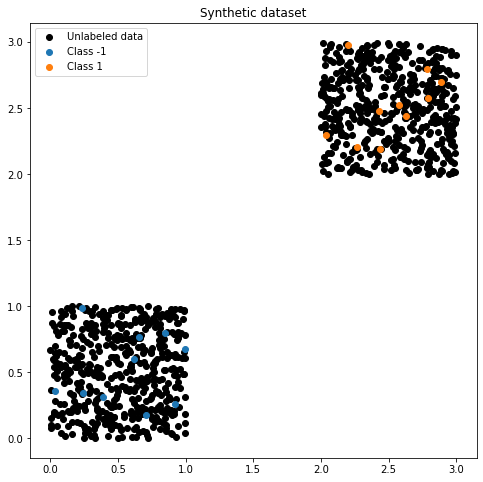

In [ ]:
LOAD = False
if LOAD:
  X_l = np.load(file_X_l)
  X_u = np.load(file_X_u)
  Y_l = np.load(file_Y_l)
else:
  u = 1000 # unlabeled subset size
  l = 20 # labeled subset size

  # First cluster (-1)
  X_l_1 = np.random.rand(int(l/2),2)
  X_u_1 = np.random.rand(int(u/2),2)
  Y_l_1 = -np.ones(int(l/2))

  #Second cluster
  X_l_2 = (np.random.rand(int(l/2),2) + 2)
  X_u_2 = (np.random.rand(int(u/2),2) + 2)
  Y_l_2 = np.ones(int(l/2))

  #Plot
  plt.figure(figsize=(8,8))
  plt.scatter(X_u_1[:,0], X_u_1[:,1],  c='k', label = "Unlabeled data")
  plt.scatter(X_l_1[:,0], X_l_1[:,1], label = "Class -1")
  plt.scatter(X_u_2[:,0], X_u_2[:,1],  c='k')
  plt.scatter(X_l_2[:,0], X_l_2[:,1], label = "Class 1")
  plt.title("Synthetic dataset")
  plt.legend()
  plt.show()

  # Join both clusters into the same dataset
  X_l = np.concatenate((X_l_1, X_l_2)) # labeled data
  X_u = np.concatenate((X_u_1, X_u_2)) # unlabeled data
  Y_l = np.concatenate((Y_l_1, Y_l_2)) #labels  

  np.save(file_X_l, X_l)
  np.save(file_X_u, X_l)
  np.save(file_Y_l, Y_l)

## 2. Choose a proper similarity measure to define $w_{ij}$ and $\overline{w_{ij}}$

Our choice of similarity measure is the inverse of the euclidean distance.

In [ ]:


def similarity(x, y, distance="euclidean"):
  if distance == "euclidean": dist = euclidean(x,y)
  elif distance == "chebyshev": dist = chebyshev(x,y)
  elif distance == "mahalanobis": dist = mahalanobis(x,y)
  elif distance == "minkowski": dist = minkowski(x,y)
  else: print("Undefined distance")
  
  if dist < 2:
    return 1/(dist+1)
  else:
    return 0
  

In [ ]:
print("Similarity between two labeled close points: ", similarity(X_l[0],X_l[1])) # large similarity of neighbouring points
print("Similarity between two labeled distant points: ", similarity(X_l[0],X_l[l-1])) #smaller similarity of distant points

Similarity between two labeled close points:  0.6310430456808832
Similarity between two labeled distant points:  0


In this plot we can see the points from which we computed the previous similarity.

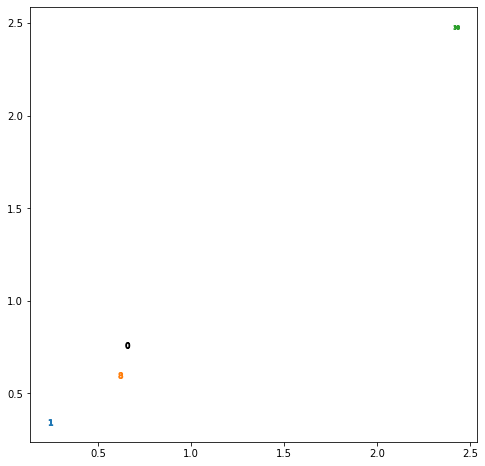

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(X_l[0,0], X_l[0,1], c = 'k', marker='$0$')
plt.scatter(X_l[1,0], X_l[1,1], marker='$1$')
plt.scatter(X_l[8,0], X_l[8,1], marker='$8$')
plt.scatter(X_l[l-2,0], X_l[l-2,1], marker='$38$')
plt.show()

In [ ]:
print(f'0->1: {similarity(X_l[0],X_l[1])}\n0->8: {similarity(X_l[0],X_l[8])} \n0->38: {similarity(X_l[0],X_l[10])}')

0->1: 0.6310430456808832
0->8: 0.8562884700316267 
0->38: 0


Definition of weights (similarity matrices).

In [ ]:
def weights(row_vec, col_vec):
  rows = len(row_vec)
  cols = len(col_vec)

  # it will become a lower triangular
  if rows == cols: #if it's a square matrix
    w = np.zeros((rows,cols), dtype=float)
    for i in range(rows):
      for j in range(cols):
        if i == j: w[i,j] = 1
        elif i<j:
          sim = similarity(row_vec[i], col_vec[j])
          w[i,j] = sim
          w[j,i] = sim
        else:
          continue

  else:
    w = np.zeros((rows,cols), dtype=float)
    for i in range(rows):
      w[i] = [similarity(row_vec[i], col_vec[j]) for j in range(cols)]

  return w

In [ ]:
# weights
if LOAD:
  w = np.load(file_weights)
else:
  w = weights(X_l,X_u) #row: labeled, col: unlabeled  
  np.save(file__weights, w)

print(w.shape)

(20, 1000)


In [ ]:
if LOAD:
  w_sign = np.load(file_symmetric_weights)
else:
  w_sign = weights(X_u,X_u) #row: labeled, col: unlabeled
  np.save(file_symmetric_weights, w_sign)
  
print(w_sign.shape)

(1000, 1000)


Assign correct labels (to test)

In [ ]:
# max function returns just the max but not the indexes of the matrix
def max_coords(col): #col is the vector
  max = [0, 0]
  for i in range(len(col)):
    if col[i] >= max[1]: max = [i, col[i]]     
  
  return max[0] #returning just the row coresponding to the labeled element

In [ ]:
# Assigning labels based on the argmax of W w.r.t. the labeled examples
Y_u = np.ones(u)

for i in range(u):
  max = max_coords(w[0:,i])
  Y_u[i] = Y_l[max]

#Y_u

Function to later plot function evaluated versus cpu time

In [ ]:
# function to plot accuracy vs time
# input: time (float), accuracy value (float), method (string)
def plot_fx_vs_cpuTime(t, function, method):
  plt.figure(figsize=(8,6))
  plt.plot(t[:len(function)], function)
  plt.title('f(x) vs CPU Time in ' + method)
  plt.xlabel('time (sec)')
  plt.ylabel('f(x)')
  plt.show()

## 3. Consider the semisupervised learning problem

Implementation of the function to minimize.

In [ ]:
def fx(w, w_sign, Y_l, Y):
  t_1 = 0
  t_2 = 0

  lblY = np.zeros((l,u), dtype=float)
  unlblY= np.zeros((u,u), dtype=float)

  for i in range(l):
    lblY[i] = (Y-Y_l[i])**2

  for i in range(u):
    unlblY[i] = (Y-Y[i])**2

  #element-wise multiplications 
  
  t_1 = np.sum(np.multiply(w, lblY))
  #print("t1: ", t_1)

  t_2 = np.sum(np.multiply(w_sign, unlblY))
  #print("t_2: ", t_2)
  return t_1 + t_2/2

In [ ]:
%%timeit
fx(w, w_sign, Y_l, Y_u)

100 loops, best of 5: 12.3 ms per loop


In [ ]:
Y = np.random.randn(u)

print("Solution theoretical")
sol = fx(w, w_sign, Y_l, Y_u)
print(sol)
print()


print("Random vector")
sol = fx(w, w_sign, Y_l, Y)
print(sol)

Solution theoretical
7181.6228913261175

Random vector
343223.5877575859


Gradient of the function

In [ ]:
def compute_constants(w, w_sign, u):
  vec1 = np.zeros(u)
  for i in range(u):
    vec1[i] = 2*np.sum(w[:, i]) + 2*np.sum(w_sign[:, i])

  vec2 = np.zeros(u)
  for i in range(u):
    vec2[i] = -2*np.dot(w[:, i], Y_l)
  return vec1, vec2

In [ ]:
vec1, vec2 = compute_constants(w, w_sign, u)

In [ ]:
def fx_gradient(w, w_sign, Y_l, Y,vec1,vec2):
  #l, u = len(Y_l),len(Y)
  
  vec = np.zeros(u)
  for i in range(u):
    vec[i] = fx_gradient_part(w, w_sign, Y_l, Y, i,vec1,vec2)
  return vec

In [ ]:
def fx_gradient_part(w, w_sign, Y_l, Y, j,vec1,vec2): #Y is just an element
  
  t_1 = Y[j] * vec1[j]
  t_2 = vec2[j]
  t_3 = -2*np.dot(np.reshape(w_sign[:, j], (len(w_sign),)), Y)

  val = t_1 + t_2 + t_3
  return val

In [ ]:
%%timeit
fx_gradient(w, w_sign, Y_l, Y_u,vec1,vec2)

100 loops, best of 5: 11.6 ms per loop


## 4. Solve the minimization problem

### 4.1 Gradient descent

**update the vector iteratively for general pourpose**

In [ ]:
def gradient_descent(y_start, l_rate, w, w_sign, Y_l, vec1, vec2,it=10000, tol=1e-3):  #gradient is the function optim.
    t = [0]  # tempo
    Y_GD = [y_start]
    start = time.time()

    for i in range(it):
      g = fx_gradient(w, w_sign, Y_l, Y_GD[i],vec1,vec2)
      if np.linalg.norm(g) <= tol:
        print("Stopping criteria: tolerance")
        break

      Y_GD.append(Y_GD[i] -l_rate * g)
      stop = time.time()
      t.append(stop - start)

      if i%100==0:
        print("ITERATION ",i)
        print("gradient: ", np.linalg.norm(g))
        print()

    if i == it: print("Stopping criteria: reached maximum number of iterations")
    return t, Y_GD

In [ ]:
y_start = np.zeros(u)
t_GD , Y_GD = gradient_descent(y_start, 1e-04, w, w_sign, Y_l,vec1,vec2)

ITERATION  0
gradient:  426.6812065849021

ITERATION  100
gradient:  328.95378362128235

ITERATION  200
gradient:  254.10773443898327

ITERATION  300
gradient:  196.29123308407364

ITERATION  400
gradient:  151.6295848441197

ITERATION  500
gradient:  117.12969666318197

ITERATION  600
gradient:  90.47948697178616

ITERATION  700
gradient:  69.89293673072014

ITERATION  800
gradient:  53.990395649681815

ITERATION  900
gradient:  41.70612205301489

ITERATION  1000
gradient:  32.21685998428475

ITERATION  1100
gradient:  24.88666699577663

ITERATION  1200
gradient:  19.22429514245385

ITERATION  1300
gradient:  14.850268979022088

ITERATION  1400
gradient:  11.471454223586356

ITERATION  1500
gradient:  8.861412753991676

ITERATION  1600
gradient:  6.845227386055137

ITERATION  1700
gradient:  5.287779434636691

ITERATION  1800
gradient:  4.084693453917103

ITERATION  1900
gradient:  3.1553422998128724

ITERATION  2000
gradient:  2.4374437342354933

ITERATION  2100
gradient:  1.88288645

In [ ]:
print("Function evaluated at correct labels:")
sol = fx(w, w_sign, Y_l, Y_u)
print(sol)
print()

print("Gradient descent minima:")
sol = fx(w, w_sign, Y_l, Y_GD[-1])
print(sol)

Function evaluated at correct labels:
7181.6228913261175

Gradient descent minima:
3369.76208087382


In [ ]:
# Store the function evaluated at the points found by gradient decent
FY_GD = []
for y in Y_GD:
  FY_GD.append(fx(w, w_sign, Y_l, y))

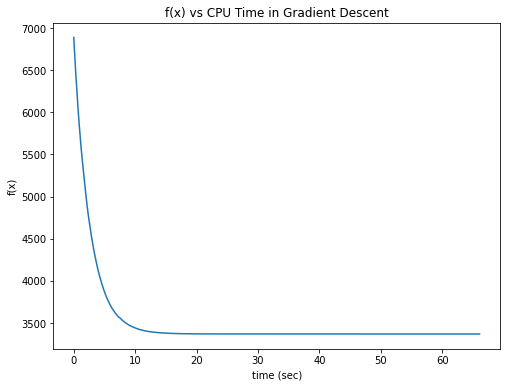

In [ ]:
plot_fx_vs_cpuTime(t_GD, FY_GD, 'Gradient Descent')

Inspect the real valued solution by gradient descent:

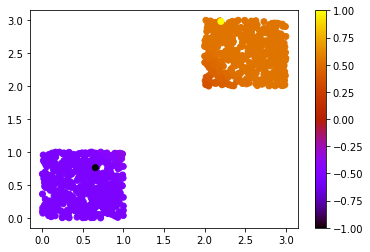

In [ ]:
lab_to_plot = np.append(Y_GD[-1], [-1,1])
coords_to_plot = np.append(X_u, [X_l[0],X_l[19]], axis=0)
unlab_plot=plt.scatter(coords_to_plot[:,0], coords_to_plot[:,1], c=lab_to_plot, cmap='gnuplot')
plt.colorbar(unlab_plot)

Assign discrete labels based on sign:

In [ ]:
Y_GD_labels = np.sign(Y_GD[-1])

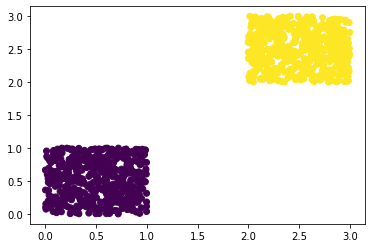

In [ ]:
plt.scatter(X_u[:,0], X_u[:,1], c=Y_GD_labels)
plt.scatter(X_l[:,0], X_l[:,1], c=Y_l)
plt.show()

In [ ]:
# optimal value for f
fx_opt = FY_GD[-1]
fx_opt

3369.76208087382

### 4.2. BCGD with randomized rule

In [ ]:
def RBCGD(y_start, l_rate, w, w_sign, Y_l, vec1, vec2, y_star, it=100000, tol=1e-4):  #gradient is the function optim.
  t = [0]  # tempo
  Y_RBCGD = np.zeros((u, it+1))
  Y_RBCGD[:,0] = y_start
  start = time.time()
  #grad = np.ones(u)

  for i in range(it):  
    if i%1000==0: #every 1000 its compute full to check stopping criteria gradient 
      #err = np.sqrt((fx(w, w_sign, Y_l, Y_RBCGD[:,i]) - fx(w, w_sign, Y_l, Y_RBCGD[:,i+1]))**2)        
      #err = np.linalg.norm(fx_gradient_new(w, w_sign, Y_l, Y_RBCGD[:, i]))
      err = np.linalg.norm(y_star -  Y_RBCGD[:,i])
      if err <1:
        print("Stopping criteria: error lower than tolerance")
        break        
      else:
        print("ITERATION ",i)
        print("error: ", err)
        print()

    ik = np.random.randint(0, u, 1) #random dimension
    g = fx_gradient_part(w, w_sign, Y_l, Y_RBCGD[:, i], ik, vec1, vec2)

    Y_RBCGD[:,i+1] = Y_RBCGD[:,i]
    Y_RBCGD[ik,i+1] -= l_rate*g
    stop = time.time()
    t.append(stop - start)

  if i == (it-1): print("Stopping criteria: reached maximum number of iterations")
  return t, Y_RBCGD, i


In [ ]:
y_start = np.zeros(u)
t_RBCGD, Y_RBCGD, last_it = RBCGD(y_start,0.001, w, w_sign, Y_l,vec1,vec2, Y_GD[-1])

ITERATION  0
error:  16.51679666196389

ITERATION  1000
error:  16.098792433659046

ITERATION  2000
error:  15.69141933687514

ITERATION  3000
error:  15.3037653209576

ITERATION  4000
error:  14.897663424323088

ITERATION  5000
error:  14.528185048799488

ITERATION  6000
error:  14.165798403181787

ITERATION  7000
error:  13.804180144102913

ITERATION  8000
error:  13.459071267184996

ITERATION  9000
error:  13.110180151889738

ITERATION  10000
error:  12.777397116146357

ITERATION  11000
error:  12.459890757884398

ITERATION  12000
error:  12.134163796450682

ITERATION  13000
error:  11.834757434181883

ITERATION  14000
error:  11.52771225851978

ITERATION  15000
error:  11.232898893003172

ITERATION  16000
error:  10.949520930072604

ITERATION  17000
error:  10.664785663495227

ITERATION  18000
error:  10.395167311914328

ITERATION  19000
error:  10.119370813407421

ITERATION  20000
error:  9.868342425043235

ITERATION  21000
error:  9.617654885987312

ITERATION  22000
error:  9.377

In [ ]:
print("Function evaluated at correct labels:")
sol = fx(w, w_sign, Y_l, Y_u)
print(sol)
print()

print("Randomized BDGD minima:")
sol = fx(w, w_sign, Y_l, Y_RBCGD[:,last_it])
print(sol)

Function evaluated at correct labels:
7181.6228913261175

Randomized BDGD minima:
3391.0606019671413


In [ ]:
# Store the function evaluated at the points found by gradient decent
import math
FY_RBCGD = []
t2 = []
for k in range(math.floor(len(t_RBCGD)/100)):
  FY_RBCGD.append(fx(w, w_sign, Y_l, Y_RBCGD[:, k*100]))
  t2.append(t_RBCGD[k*100])

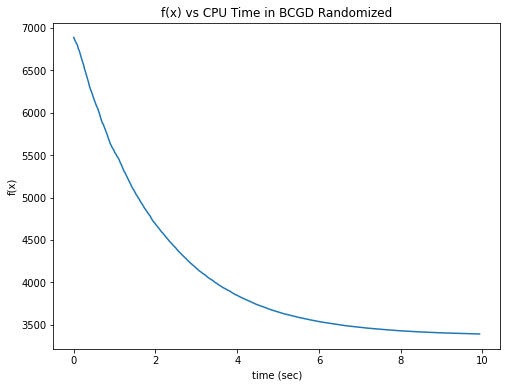

In [ ]:
plot_fx_vs_cpuTime(t2, FY_RBCGD[:-1], 'BCGD Randomized')

In [ ]:
fx_opt

3369.76208087382

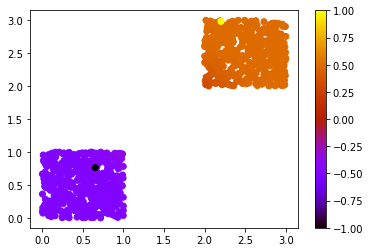

In [ ]:
lab_to_plot = np.append(Y_RBCGD[:,last_it], [-1,1])
coords_to_plot = np.append(X_u, [X_l[0],X_l[19]], axis=0)
unlab_plot=plt.scatter(coords_to_plot[:,0], coords_to_plot[:,1], c=lab_to_plot, cmap='gnuplot')
plt.colorbar(unlab_plot)

In [ ]:
Y_RBCGD_labels = np.sign(Y_RBCGD[:, last_it])

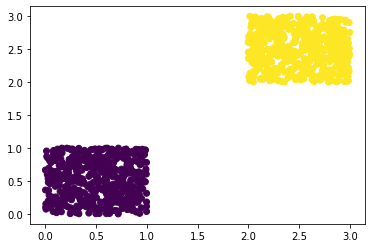

In [ ]:
plt.scatter(X_u[:,0], X_u[:,1], c=Y_RBCGD_labels)
plt.scatter(X_l[:,0], X_l[:,1], c=Y_l)
plt.show()

### 4.3 BCGD with cyclic rule

In [ ]:
def CBCGD(y_start, l_rate, w, w_sign, Y_l, vec1, vec2, y_star, it=2000, tol=1e-3):  #gradient is the function optim.
    t = [0]  # tempo
    Y_CBCGD = np.zeros((u, it+1))
    Y_CBCGD[:,0] = y_start
    start = time.time()
    for i in range(it):
      if i%100==0:
        #err = np.sqrt((fx(w, w_sign, Y_l, Y_CBCGD[:,i]) - fx(w, w_sign, Y_l, Y_CBCGD[:,i+1]))**2)
        #err = np.linalg.norm(fx_gradient_new(w, w_sign, Y_l, Y_CBCGD[:, i]))
        err = np.linalg.norm( y_star -  Y_CBCGD[:,i])
        if err <1:
          print("Stopping criteria: error lower than tolerance")
          break
        elif err == np.inf:
          print("Divergence error")
          break
        else:
          print("ITERATION ",i)
          print("error: ", err)
          print()
        
      Y_CBCGD[:,i+1] = Y_CBCGD[:,i]
        
      for ik in range(u):
        g = fx_gradient_part(w, w_sign, Y_l, Y_CBCGD[:, i+1], ik, vec1, vec2)
        Y_CBCGD[ik,i+1] -= l_rate*g

      stop = time.time()
      t.append(stop - start)
  
    if i == (it-1): print("Stopping criteria: reached maximum number of iterations")
    return t, Y_CBCGD, i

In [ ]:
y_start = np.zeros(u)
t_CBCGD, Y_CBCGD, last_it = CBCGD(y_start, 1e-03, w, w_sign, Y_l,vec1,vec2, Y_GD[-1])

ITERATION  0
error:  16.51679666196389

Stopping criteria: error lower than tolerance


In [ ]:
print("Solution theoretical")
sol = fx(w, w_sign, Y_l, Y_u)
print(sol)
print()


print("GD vector solution")
sol = fx(w, w_sign, Y_l, Y_CBCGD[:,last_it])
print(sol)

Solution theoretical
7181.6228913261175

GD vector solution
3371.0567919405457


In [ ]:
fx_opt

3369.76208087382

In [ ]:
# Store the function evaluated at the points found by gradient decent
FY_CBCGD = []
for k in range(len(t_CBCGD)):
  FY_CBCGD.append(fx(w, w_sign, Y_l, Y_CBCGD[:, k]))

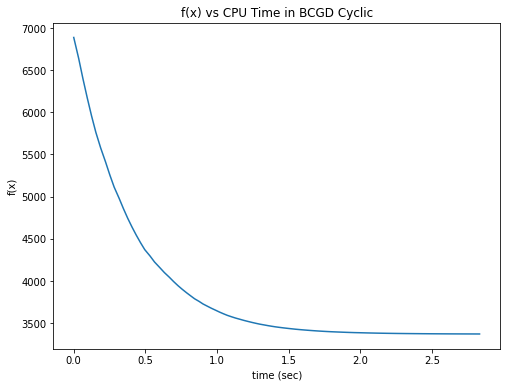

In [ ]:
plot_fx_vs_cpuTime(t_CBCGD, FY_CBCGD[:-1], 'BCGD Cyclic')

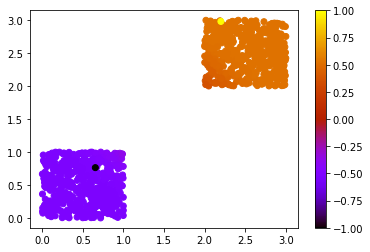

In [ ]:
lab_to_plot = np.append(Y_CBCGD[:,last_it], [-1,1])
coords_to_plot = np.append(X_u, [X_l[0],X_l[19]], axis=0)
unlab_plot=plt.scatter(coords_to_plot[:,0], coords_to_plot[:,1], c=lab_to_plot, cmap='gnuplot')
plt.colorbar(unlab_plot)

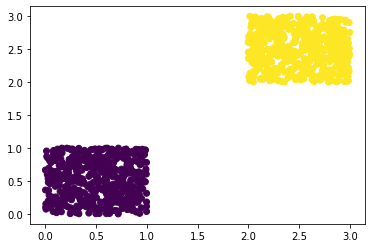

In [ ]:
Y_CBCGD_labels = np.sign(Y_CBCGD[:, last_it])
plt.scatter(X_u[:,0], X_u[:,1], c=Y_RBCGD_labels)
plt.scatter(X_l[:,0], X_l[:,1], c=Y_l)
plt.show()

## 6. Analyze accuracy vs CPU time

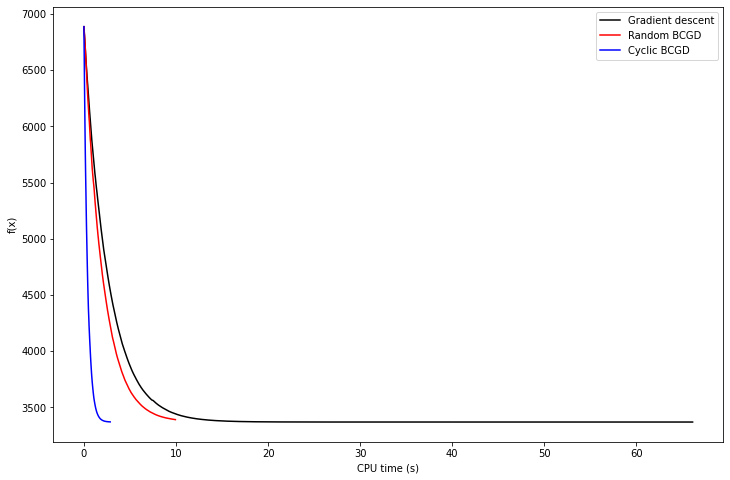

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(t_GD, FY_GD, c='k', label="Gradient descent")
plt.plot(t2, FY_RBCGD, c='r', label="Random BCGD")
plt.plot(t_CBCGD, FY_CBCGD, c='b', label="Cyclic BCGD")
plt.legend()
plt.xlabel("CPU time (s)")
plt.ylabel("f(x)")
plt.savefig("../output/synth_cpu_time")
plt.show()

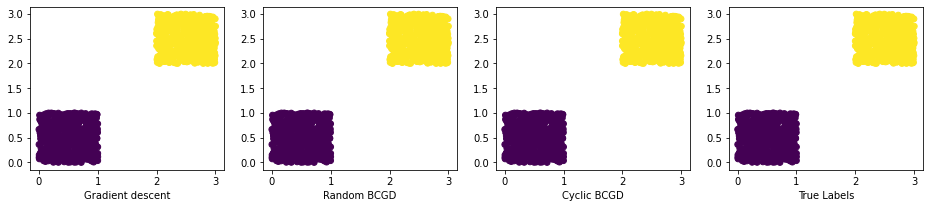

In [ ]:
plt.figure(figsize=(16,3))
plt.title("Labels by different optimization methods")
plt.subplot(141)
plt.scatter(X_u[:,0], X_u[:,1], c=Y_GD_labels)
plt.scatter(X_l[:,0], X_l[:,1], c=Y_l)
plt.xlabel("Gradient descent")
plt.subplot(142)
plt.scatter(X_u[:,0], X_u[:,1], c=Y_RBCGD_labels)
plt.scatter(X_l[:,0], X_l[:,1], c=Y_l)
plt.xlabel("Random BCGD")
plt.subplot(143)
plt.scatter(X_u[:,0], X_u[:,1], c=Y_CBCGD_labels)
plt.scatter(X_l[:,0], X_l[:,1], c=Y_l)
plt.xlabel("Cyclic BCGD")
plt.subplot(144)
plt.scatter(X_u[:,0], X_u[:,1], c=Y_u)
plt.scatter(X_l[:,0], X_l[:,1], c=Y_l)
plt.xlabel("True Labels")
plt.savefig("../output/synth_labels")
plt.show()

## 5. Choose a publicly available dataset and test the methods

In [ ]:
df = pd.read_csv("data_banknote_authentication.csv", header=None).sample(frac=1)
df.head(100)

,0,1,2,3,4
1024,-3.00610,-12.2377,11.95520,-2.16030,1
405,0.58982,7.4266,1.23530,-2.95950,0
188,4.56450,-3.6275,2.86840,0.27714,0
1254,-3.88940,-7.8322,9.82080,0.47498,1
1226,-4.06790,2.4955,0.79571,-1.10390,1
...,...,...,...,...,...
731,1.01820,9.1090,-0.62064,-1.71290,0
974,-5.03010,7.5032,-0.13396,-7.50340,1
684,-2.07590,10.8223,2.64390,-4.83700,0
1268,-3.94110,-12.8792,13.05970,-3.31250,1


In [ ]:
sc = StandardScaler()
df[[0,1,2,3]] = sc.fit_transform(df[[0,1,2,3]])
df.loc[df[4] == 0, 4] = -1
df.head()

,0,1,2,3,4
1024,-1.210474,-2.413546,2.450429,-0.461204,1
405,0.054926,0.938185,-0.037676,-0.841731,-1
188,1.453611,-0.945959,0.341369,0.699345,-1
1254,-1.521306,-1.662640,1.955031,0.793543,1
1226,-1.584120,0.097691,-0.139706,0.041784,1


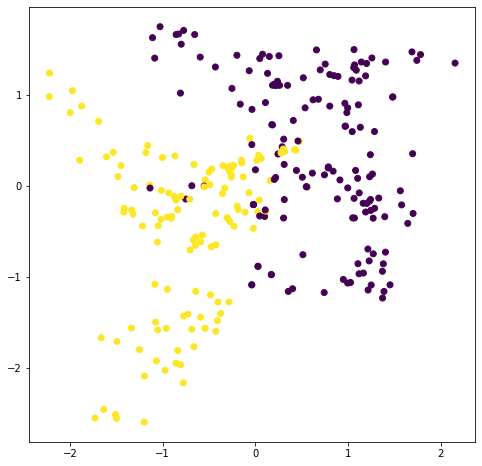

In [ ]:
u = round(len(df)*0.8)
l = round(len(df)*0.2)
X_u = df[[0,1,2,3]].iloc[:u].values
X_l = df[[0,1,2,3]].iloc[u:].values
Y_l = df[[4]].iloc[u:].values.reshape(l)
Y_u = df[[4]].iloc[:u].values.reshape(u)

plt.figure(figsize=(8,8))
#plt.scatter(X_u[:,0], X_u[:,1])
plt.scatter(X_l[:,0], X_l[:,1],c=Y_l)
plt.show()

In [ ]:
w = weights(X_l,X_u)

In [ ]:
w_sign = weights(X_u,X_u)

In [ ]:
vec1, vec2 = compute_constants(w, w_sign, u)

In [ ]:
y_start = np.zeros(u)
t_GD , Y_GD = gradient_descent(y_start, 1e-03, w, w_sign, Y_l,vec1,vec2)

ITERATION  0
gradient:  1386.7060601242647

ITERATION  100
gradient:  5.062134640994993

ITERATION  200
gradient:  0.40780422918783604

ITERATION  300
gradient:  0.03299593975517632

ITERATION  400
gradient:  0.0026703529087728508

Stopping criteria: tolerance


In [ ]:
FY_GD = []
for y in Y_GD:
  FY_GD.append(fx(w, w_sign, Y_l, y))
Y_GD_labels = np.sign(Y_GD[-1])


In [ ]:
y_start = np.zeros(u)
t_RBCGD, Y_RBCGD, last_it = RBCGD(y_start, 1e-03, w, w_sign, Y_l, vec1, vec2, FY_GD[-1],it=100000)

ITERATION  0
error:  1515101.1958178838

ITERATION  1000
error:  1515101.6704864611

ITERATION  2000
error:  1515102.0614798912

ITERATION  3000
error:  1515102.3851421848

ITERATION  4000
error:  1515102.7194787203

ITERATION  5000
error:  1515102.9636319585

ITERATION  6000
error:  1515103.2115440432

ITERATION  7000
error:  1515103.4549551406

ITERATION  8000
error:  1515103.6462981713

ITERATION  9000
error:  1515103.8319729406

ITERATION  10000
error:  1515104.002227325

ITERATION  11000
error:  1515104.137654082

ITERATION  12000
error:  1515104.2659167107

ITERATION  13000
error:  1515104.3835711358

ITERATION  14000
error:  1515104.4953856794

ITERATION  15000
error:  1515104.5909367248

ITERATION  16000
error:  1515104.6713817606

ITERATION  17000
error:  1515104.7478095063

ITERATION  18000
error:  1515104.8165345308

ITERATION  19000
error:  1515104.876119592

ITERATION  20000
error:  1515104.929996478

ITERATION  21000
error:  1515104.9845183175

ITERATION  22000
error:  15

In [ ]:
import math
FY_RBCGD = []
t2 = []
for k in range(math.floor(len(t_RBCGD)/100)):
  FY_RBCGD.append(fx(w, w_sign, Y_l, Y_RBCGD[:, k*100]))
  t2.append(t_RBCGD[k*100])
Y_RBCGD_labels = np.sign(Y_RBCGD[:, last_it])

In [ ]:
y_start = np.zeros(u)
t_CBCGD, Y_CBCGD, last_it = CBCGD(y_start, 1e-03, w, w_sign, Y_l,vec1,vec2, FY_GD[-1], it=1000)

ITERATION  0
error:  1515101.1958178838

ITERATION  100
error:  1515105.2976847638

ITERATION  200
error:  1515105.267069246

ITERATION  300
error:  1515105.2646850373

ITERATION  400
error:  1515105.2644963898

ITERATION  500
error:  1515105.264481518

ITERATION  600
error:  1515105.2644803475

ITERATION  700
error:  1515105.2644802553

ITERATION  800
error:  1515105.2644802483

ITERATION  900
error:  1515105.2644802474

Stopping criteria: reached maximum number of iterations


In [ ]:
FY_CBCGD = []
for k in range(len(t_CBCGD)):
  FY_CBCGD.append(fx(w, w_sign, Y_l, Y_CBCGD[:, k]))
Y_CBCGD_labels = np.sign(Y_CBCGD[:, last_it])

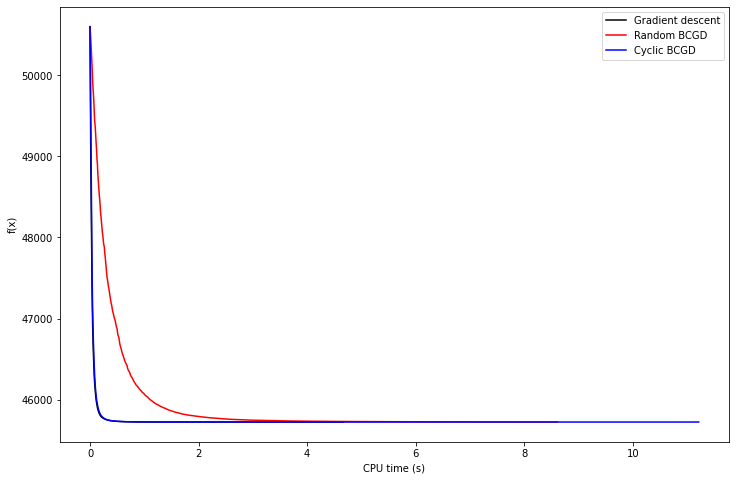

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(t_GD, FY_GD, c='k', label="Gradient descent")
plt.plot(t2, FY_RBCGD, c='r', label="Random BCGD")
plt.plot(t_CBCGD, FY_CBCGD, c='b', label="Cyclic BCGD")
plt.xlabel("CPU time (s)")
plt.ylabel("f(x)")
plt.legend()
plt.savefig("../output/real__cpu_time")
plt.show()

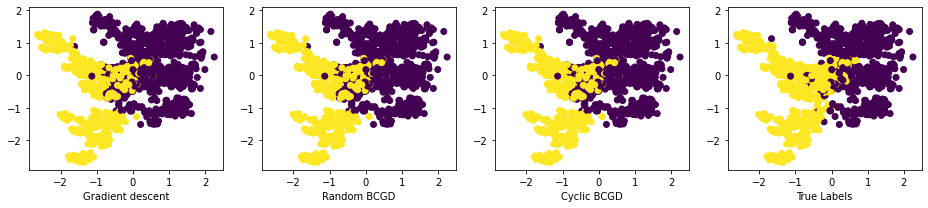

In [ ]:
plt.figure(figsize=(16,3))
plt.title("Labels by different optimization methods")
plt.subplot(141)
plt.scatter(X_u[:,0], X_u[:,1], c=Y_GD_labels)
plt.scatter(X_l[:,0], X_l[:,1], c=Y_l)
plt.xlabel("Gradient descent")
plt.subplot(142)
plt.scatter(X_u[:,0], X_u[:,1], c=Y_RBCGD_labels)
plt.scatter(X_l[:,0], X_l[:,1], c=Y_l)
plt.xlabel("Random BCGD")
plt.subplot(143)
plt.scatter(X_u[:,0], X_u[:,1], c=Y_CBCGD_labels)
plt.scatter(X_l[:,0], X_l[:,1], c=Y_l)
plt.xlabel("Cyclic BCGD")
plt.subplot(144)
plt.scatter(X_u[:,0], X_u[:,1], c=Y_u)
plt.scatter(X_l[:,0], X_l[:,1], c=Y_l)
plt.xlabel("True Labels")
plt.savefig("../output/real_labels")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
print("Gradient descent accuracy:", accuracy_score(Y_u, Y_GD_labels))
print("Random BCGD:", accuracy_score(Y_u, Y_RBCGD_labels))
print("Cyclic BCGD:", accuracy_score(Y_u, Y_CBCGD_labels))

Gradient descent accuracy: 0.8096539162112932
Random BCGD: 0.8087431693989071
Cyclic BCGD: 0.8096539162112932
